## **Recommendation System for Amazon Outdoor Products.** 
**Author:** Elena Burlando

# EDA Notebook

This project was developed in Google Colab. With respect to Google Colab's runtime restrictions, the decision was made to break down the project into multiple notebooks vs to keep everything in one notebook. 

EDA notebook is the first notebook that is covering data, business problem, data preeprocessing, and exploratory analysis. 

Model notebooks are located in the same GitHub repo under [models](https://github.com/rusalka013/Amazon_Rec_Systems/tree/main/models) folder. They are listed iin a numerical order with a short description of task in its name. Our best performing model is [model_5](https://github.com/rusalka013/Amazon_Rec_Systems/blob/main/models/model_5_Retrieval_item_item_fine_tuned_full_dataset.ipynb) (Retrieval item-to-item fine-tuned model). 

### Overview

For this project we will be exploring Neural Networks to build recommendation systems for Amazon Outdoor product reviews dataset. TensorFlow Recommenders will be used to develop Retrieval, Ranking, and Sequential algorithms. BruteForce and ScaNN will be tested for serving models. 

### Business Problem

According to Statista, the Sports and Outdoor market segment is projected to reach 20.75bn US dollars in 2022 with an annual growth rate of 13.29% ([link to source](https://www.statista.com/outlook/dmo/ecommerce/toys-hobby-diy/sports-outdoor/united-states)). User penetration is expected to be 20% in 2022 and 22.2% by 2025. However, with a projected market volume of 23,890.00m US dollars in 2022, most revenue will be coming from China. The average revenue per customer is set to be 310.00 US dollars. 

With the above statistics in mind, Amazon has been looking into further increasing user penetration locally in US thus driving increase in sales and revenue. One of the strategies is to build a rec system to deal with a cold-start problem in order to acquire new users. For this problem we will explore neural networks by using TensorFlow Recommenders. 

The target audience is the stakeholders of a marketing team of Amazon.com.


### Data


* [Amazon Reviews: Outdoors](https://www.tensorflow.org/datasets/catalog/amazon_us_reviews)

Amazon Review datasets has an expansive records of reviews spanning for over 20 years from 1995 through 2015. I picked 'Outdoor' category due to my passion for nature and assumption that to some extend most people have at least one outdoor activity that they like. The last point is to find a few people to test a final model in real life. 
Outdoor dataset has over 2.3M review entries. I will only use 5% of data that corresponds to 115120 entries to develop and test models. 

A note on dataset (from Amazon): 
* Dataset is in TCV file format. 
*  Each line in the data files corresponds to an individual review (tab delimited, with no quote and escape characters).
* 'product_pareent' - random ideentifier that can be used to aggregate reviews for the same product. 
* 'total_votes' - number of total votes the review received.
* 'helpful votes' - number of helpful votes.
* 'vine' - review has been written as a part of the Vine program.
* Rating Scale is 1-5. 


**Target & Metrics**
***
* The target variable is rating.
* The main metric is Accuracy Rate and RMSE for Ranking models. 
* The second important metric is Top-n recommendations. The final algorithms will be tested on multiple users to determine model subjective performance. 
* We intend to use Neural Network TensorFlow Recommenders to test and develop a new Recommendation system.  
* We will be following CRISP-DM process for this project. 
***


Importing Libraries

In [ ]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! pip install -q tensorflow-recommenders
! pip install -q --upgrade tensorflow-datasets

     |████████████████████████████████| 88 kB 4.0 MB/s 
     |████████████████████████████████| 578.0 MB 14 kB/s 
     |████████████████████████████████| 5.9 MB 61.4 MB/s 
     |████████████████████████████████| 1.7 MB 71.7 MB/s 
     |████████████████████████████████| 438 kB 69.9 MB/s 


In [ ]:
# import libraries
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_recommenders as tfrs

# import interactive table 
from google.colab import data_table
data_table.enable_dataframe_formatter()

# set seed
tf.random.set_seed(42)

Loading and processing Amazon reviews (subset: Outdoors) data.

In [ ]:
# load data

ratings, info = tfds.load("amazon_us_reviews/Outdoors_v1_00", split="train[:5%]", with_info = True)

for x in ratings.take(1).as_numpy_iterator():
  pprint.pprint(x)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2302401 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/amazon_us_reviews/Outdoors_v1_00/0.1.0.incompleteQRPFLL/amazon_us_reviews-trai…

Dataset amazon_us_reviews downloaded and prepared to ~/tensorflow_datasets/amazon_us_reviews/Outdoors_v1_00/0.1.0. Subsequent calls will reuse this data.
{'data': {'customer_id': b'49951471',
          'helpful_votes': 0,
          'marketplace': b'US',
          'product_category': b'Outdoors',
          'product_id': b'B00SF0KMV4',
          'product_parent': b'286179117',
          'product_title': b'WaterVault Thermos Water Bottle - Double Insulat'
                           b'ed Copper Plated Stainless Steel - Keeps Hot 12 '
                           b'Hours, Cold up to 36 - BPA-Free (12oz, 17oz, 26o'
                           b'z, 1 liter) Assorted Colors',
          'review_body': b"Amazing!. The water does get colder and it's durable"
                         b". Just don't leave in the sun cause it can get red h"
                         b'ot, but the water inside is still cold!',
          'review_date': b'2015-08-27',
          'review_headline': b"Amazing!. The water does

Saving data subset to G-Drive. 

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gdrive_path = '/content/drive/MyDrive/ModelingData'
path = os.path.join(gdrive_path, "ratings")
# Save a dataset
ratings.save(path)
ratings = tf.data.Dataset.load(path)

## EDA

#### Data Preprocessing

Loading data subset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gdrive_path = '/content/drive/MyDrive/ModelingData'
path = os.path.join(gdrive_path, "ratings")

ratings = tf.data.Dataset.load(path)

Importing Dataset to Pandas to perform EDA.

In [ ]:
# import to pandas 
ratings_pd = tfds.as_dataframe(ratings)

In [ ]:
# look at the first 5 rows
ratings_pd.head()

,data/customer_id,data/helpful_votes,data/marketplace,data/product_category,data/product_id,data/product_parent,data/product_title,data/review_body,data/review_date,data/review_headline,data/review_id,data/star_rating,data/total_votes,data/verified_purchase,data/vine
0,b'49951471',0,b'US',b'Outdoors',b'B00SF0KMV4',b'286179117',b'WaterVault Thermos Water Bottle - Double Ins...,"b""Amazing!. The water does get colder and it's...",b'2015-08-27',"b""Amazing!. The water does get colder and it's...",b'R174YYD49MPTIG',5,0,0,1
1,b'23055861',1,b'US',b'Outdoors',b'B000NV9W1E',b'89646415',b'Stearns Sospenders Manual Inflatable Life Ja...,b'I have been looking for this type of PFD for...,b'2011-04-05',b'Right On!',b'R3L4UFPSTDJTBR',4,2,0,1
2,b'52812229',1,b'US',b'Outdoors',b'B00IYG2NT8',b'123743722',b'Vader Bicycle Cycling Bike Road Offroad MTB ...,b'I had high expectations after reading so man...,b'2015-02-14',b'Too hard and gives me saddle sores',b'R11QYR5XULZZ5N',2,2,0,1
3,b'15637406',0,b'US',b'Outdoors',b'B003ZM9RX6',b'432885265',"b'Shimano Acera SL-M310 Rapid Fire Shifter, Ri...","b'Two years later, it still performs flawlessl...",b'2014-04-12',b'Fantastic design and performance',b'R28VJQDJTQ4ZCF',5,0,0,1
4,b'47104647',2,b'US',b'Outdoors',b'B00CHICVL4',b'190233044',"b""Women's Cycling Biking Pants Underwear Bike ...",b'I ordered the pants that should fit a size 6...,b'2013-07-28',b'bad sizing',b'RW71N05GK4LXZ',2,2,0,1


In [ ]:
ratings_pd.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 115120 entries, 0 to 115119
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   data/customer_id        115120 non-null  object
 1   data/helpful_votes      115120 non-null  int32 
 2   data/marketplace        115120 non-null  object
 3   data/product_category   115120 non-null  object
 4   data/product_id         115120 non-null  object
 5   data/product_parent     115120 non-null  object
 6   data/product_title      115120 non-null  object
 7   data/review_body        115120 non-null  object
 8   data/review_date        115120 non-null  object
 9   data/review_headline    115120 non-null  object
 10  data/review_id          115120 non-null  object
 11  data/star_rating        115120 non-null  int32 
 12  data/total_votes        115120 non-null  int32 
 13  data/verified_purchase  115120 non-null  int64 
 14  data/vine 

In [ ]:
ratings_pd.isnull().sum()

data/customer_id          0
data/helpful_votes        0
data/marketplace          0
data/product_category     0
data/product_id           0
data/product_parent       0
data/product_title        0
data/review_body          0
data/review_date          0
data/review_headline      0
data/review_id            0
data/star_rating          0
data/total_votes          0
data/verified_purchase    0
data/vine                 0
dtype: int64

In [ ]:
# clean column names by getting rid of 'data/' in its names. 
ratings_pd.columns = ratings_pd.columns.str.replace('data/', '')

In [ ]:
ratings_pd.head(1)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes,verified_purchase,vine
0,b'49951471',0,b'US',b'Outdoors',b'B00SF0KMV4',b'286179117',b'WaterVault Thermos Water Bottle - Double Ins...,"b""Amazing!. The water does get colder and it's...",b'2015-08-27',"b""Amazing!. The water does get colder and it's...",b'R174YYD49MPTIG',5,0,0,1


In [ ]:
# string decode
columns_str = ratings_pd.select_dtypes('object')

for col in columns_str: 
  ratings_pd[col] = ratings_pd[col].str.decode('utf-8')


In [ ]:
ratings_pd.head()

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes,verified_purchase,vine
0,49951471,0,US,Outdoors,B00SF0KMV4,286179117,WaterVault Thermos Water Bottle - Double Insul...,Amazing!. The water does get colder and it's d...,2015-08-27,Amazing!. The water does get colder and it's ...,R174YYD49MPTIG,5,0,0,1
1,23055861,1,US,Outdoors,B000NV9W1E,89646415,Stearns Sospenders Manual Inflatable Life Jacket,I have been looking for this type of PFD for a...,2011-04-05,Right On!,R3L4UFPSTDJTBR,4,2,0,1
2,52812229,1,US,Outdoors,B00IYG2NT8,123743722,Vader Bicycle Cycling Bike Road Offroad MTB Mo...,I had high expectations after reading so many ...,2015-02-14,Too hard and gives me saddle sores,R11QYR5XULZZ5N,2,2,0,1
3,15637406,0,US,Outdoors,B003ZM9RX6,432885265,"Shimano Acera SL-M310 Rapid Fire Shifter, Righ...","Two years later, it still performs flawlessly ...",2014-04-12,Fantastic design and performance,R28VJQDJTQ4ZCF,5,0,0,1
4,47104647,2,US,Outdoors,B00CHICVL4,190233044,Women's Cycling Biking Pants Underwear Bike Bi...,I ordered the pants that should fit a size 6 p...,2013-07-28,bad sizing,RW71N05GK4LXZ,2,2,0,1


In [ ]:
# 'review_date' col to datetime format
ratings_pd.review_date = pd.to_datetime(ratings_pd.review_date)

In [ ]:
ratings_pd.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 115120 entries, 0 to 115119
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   customer_id        115120 non-null  object        
 1   helpful_votes      115120 non-null  int32         
 2   marketplace        115120 non-null  object        
 3   product_category   115120 non-null  object        
 4   product_id         115120 non-null  object        
 5   product_parent     115120 non-null  object        
 6   product_title      115120 non-null  object        
 7   review_body        115120 non-null  object        
 8   review_date        115120 non-null  datetime64[ns]
 9   review_headline    115120 non-null  object        
 10  review_id          115120 non-null  object        
 11  star_rating        115120 non-null  int32         
 12  total_votes        115120 non-null  int32         
 13  verified_purchase 

In [ ]:
# saving ratings_pd as csv to G-Drive

path_csv = ('/content/drive/MyDrive/ModelingData/ratings.csv')
with open(path_csv, 'w', encoding = 'utf-8-sig') as f: 
  ratings_pd.to_csv(f)

#### Descriptive Statistics

In [ ]:
# setting consistent plotting
plt.style.use('ggplot')


In [ ]:
# looking at statistics
ratings_pd.describe()

,data/helpful_votes,data/star_rating,data/total_votes,data/verified_purchase,data/vine
count,115120.000000,115120.000000,115120.000000,115120.000000,115120.000000
mean,1.841200,4.242512,2.287509,0.120214,0.998732
std,11.947794,1.210652,12.702373,0.325213,0.035590
min,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,0.000000,0.000000,1.000000
50%,0.000000,5.000000,0.000000,0.000000,1.000000
75%,1.000000,5.000000,1.000000,0.000000,1.000000
max,1326.000000,5.000000,1352.000000,1.000000,1.000000


In [ ]:
# Looking at Pearson correlation
ratings_pd.corr()

,helpful_votes,star_rating,total_votes,verified_purchase,vine
helpful_votes,1.000000,-0.036747,0.989465,0.065163,-0.000739
star_rating,-0.036747,1.000000,-0.065950,-0.064118,-0.003950
total_votes,0.989465,-0.065950,1.000000,0.072758,-0.002210
verified_purchase,0.065163,-0.064118,0.072758,1.000000,-0.096402
vine,-0.000739,-0.003950,-0.002210,-0.096402,1.000000


In [ ]:
# unique values per column
for col in ratings_pd: 
  print(f'{col} column unique values: {ratings_pd[col].nunique()}')

customer_id column unique values: 109308
helpful_votes column unique values: 219
marketplace column unique values: 1
product_category column unique values: 1
product_id column unique values: 59607
product_parent column unique values: 46683
product_title column unique values: 46438
review_body column unique values: 111138
review_date column unique values: 3225
review_headline column unique values: 76401
review_id column unique values: 115120
star_rating column unique values: 5
total_votes column unique values: 238
verified_purchase column unique values: 2
vine column unique values: 2
review_day column unique values: 7
review_year column unique values: 16
review_month column unique values: 12


In [ ]:
# checking on duplicates
ratings_pd.duplicated().sum()

0

In [ ]:
# number of unique values for numeric columns
column_num = ['helpful_votes', 'star_rating', 'total_votes', 'verified_purchase', 'vine']

for col in column_num: 
  print(f'{col} column unique values: {ratings_pd[col].nunique()}')

helpful_votes column unique values: 219
star_rating column unique values: 5
total_votes column unique values: 238
verified_purchase column unique values: 2
vine column unique values: 2


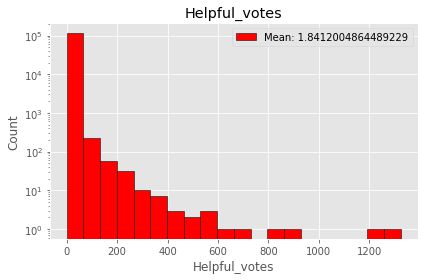

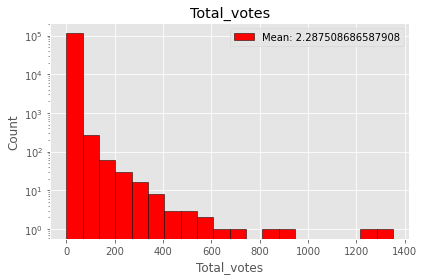

In [ ]:
# looking at the distribution of numeric columns with 200+ unique values
column_numeric = ['helpful_votes', 'total_votes']

for col in column_numeric:
  plt.hist(ratings_pd[col], bins = 20, color = 'red', edgecolor = 'black', label = f'Mean: {ratings_pd[col].mean()}', 
           log = True) 

  plt.legend()
  plt.title(f'{col.capitalize()}')
  plt.xlabel(f'{col.capitalize()}')
  plt.ylabel('Count')

  plt.tight_layout()
  plt.show()

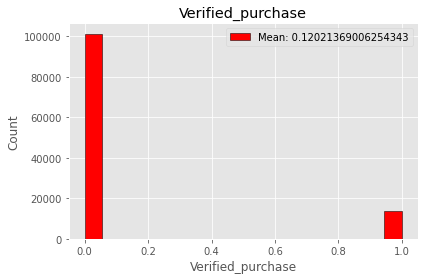

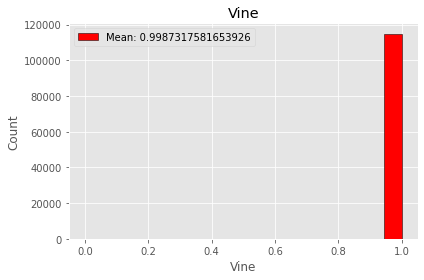

In [ ]:
# looking at the distribution of binary columns
column_binary = ['verified_purchase', 'vine']

for col in column_binary:
  plt.hist(ratings_pd[col], bins = 'auto', color = 'red', edgecolor = 'black', label = f'Mean: {ratings_pd[col].mean()}') 

  plt.legend()
  plt.title(f'{col.capitalize()}')
  plt.xlabel(f'{col.capitalize()}')
  plt.ylabel('Count')

  plt.tight_layout()
  plt.show()

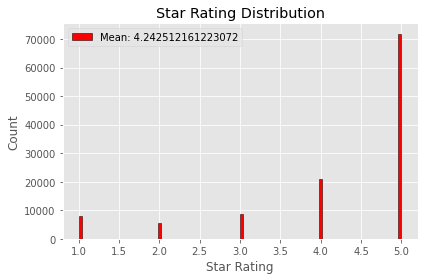

In [ ]:
# looking at the distribution of ratings
star_rating = ratings_pd.star_rating

plt.hist(star_rating, bins = 'auto', color = 'red', edgecolor = 'black', 
         label = f'Mean: {star_rating.mean()}') 

plt.legend()
plt.title('Star Rating Distribution')
plt.xlabel('Star Rating')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
ratings_pd.star_rating.value_counts(normalize = True)

5    0.624626
4    0.181489
3    0.076294
1    0.070639
2    0.046951
Name: star_rating, dtype: float64

Over 62% of customers left 5 star rating review followed by ~18% of 4 star rating. 

#### Timestamp

In this section we will take a look at the 'review_date' column. 

In [ ]:
# review date range
print(f'Review date range: {ratings_pd.review_date.min()} - {ratings_pd.review_date.max()}')

Review date range: 2000-10-08 00:00:00 - 2015-08-31 00:00:00


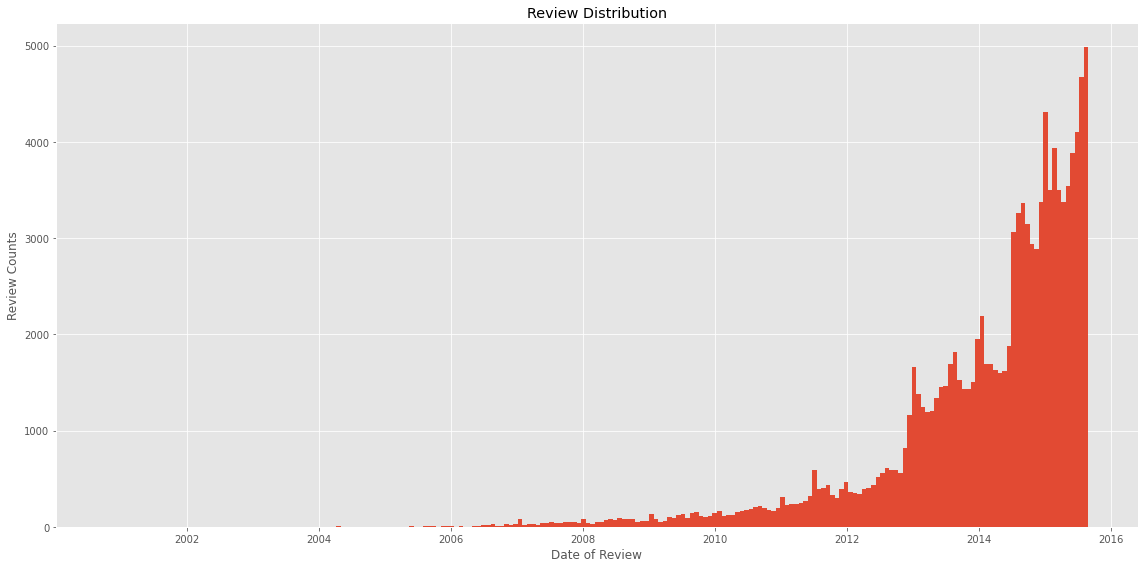

In [ ]:
# historical review distribution

fig, ax = plt.subplots(figsize = (16, 8))
ax.hist(ratings_pd['review_date'], bins = 'auto')
ax.set_title('Review Distribution')
ax.set_xlabel('Date of Review')
ax.set_ylabel('Review Counts')

plt.tight_layout()
plt.show;

Since 2008 the number of reviews has been progressively increasing each year with more than doubling at 2013. 

In [ ]:
# create a 'review_day' column for review
ratings_pd['review_day'] = ratings_pd.review_date.dt.day_name()
ratings_pd.head(1)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes,verified_purchase,vine,review_day
0,49951471,0,US,Outdoors,B00SF0KMV4,286179117,WaterVault Thermos Water Bottle - Double Insul...,Amazing!. The water does get colder and it's d...,2015-08-27,Amazing!. The water does get colder and it's ...,R174YYD49MPTIG,5,0,0,1,Thursday


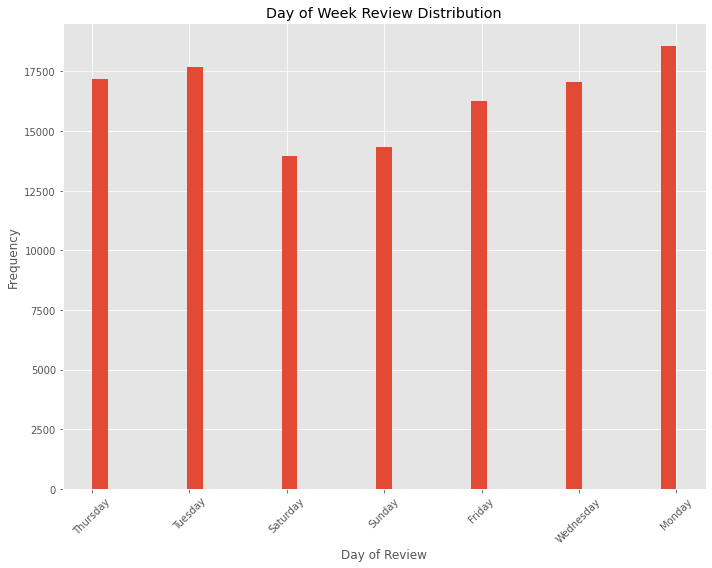

In [ ]:
# Let's look at the 'review_day' distribution

fig, ax = plt.subplots(figsize = (10, 8))
ax.hist(ratings_pd['review_day'], bins = 'auto')
ax.set_title('Day of Week Review Distribution')
ax.set_xlabel('Day of Review')
ax.set_ylabel('Frequency')

plt.xticks(rotation = 45)
plt.tight_layout()
plt.show;

Customers tend to leave reviews at the beginning of the week. 

In [ ]:
# create 'review_year' column
ratings_pd['review_year'] = ratings_pd.review_date.dt.year
ratings_pd.head(1)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes,verified_purchase,vine,review_day,review_year
0,49951471,0,US,Outdoors,B00SF0KMV4,286179117,WaterVault Thermos Water Bottle - Double Insul...,Amazing!. The water does get colder and it's d...,2015-08-27,Amazing!. The water does get colder and it's ...,R174YYD49MPTIG,5,0,0,1,Thursday,2015


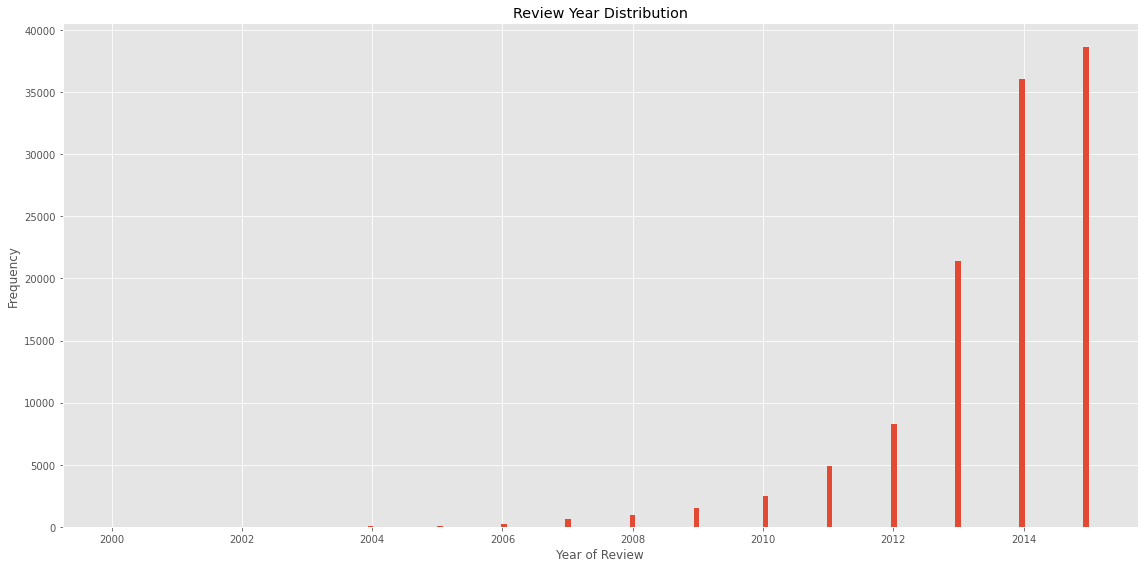

In [ ]:
# Let's look at the 'review_year' distribution

fig, ax = plt.subplots(figsize = (16, 8))
ax.hist(ratings_pd['review_year'], bins = 'auto')
ax.set_title('Review Year Distribution')
ax.set_xlabel('Year of Review')
ax.set_ylabel('Frequency')

plt.xticks(rotation = 0)
plt.tight_layout()
plt.show;

In [ ]:
# create 'review_month' column
ratings_pd['review_month'] = ratings_pd.review_date.dt.month_name()
ratings_pd.head(1)

,customer_id,helpful_votes,marketplace,product_category,product_id,product_parent,product_title,review_body,review_date,review_headline,review_id,star_rating,total_votes,verified_purchase,vine,review_day,review_year,review_month
0,49951471,0,US,Outdoors,B00SF0KMV4,286179117,WaterVault Thermos Water Bottle - Double Insul...,Amazing!. The water does get colder and it's d...,2015-08-27,Amazing!. The water does get colder and it's ...,R174YYD49MPTIG,5,0,0,1,Thursday,2015,August


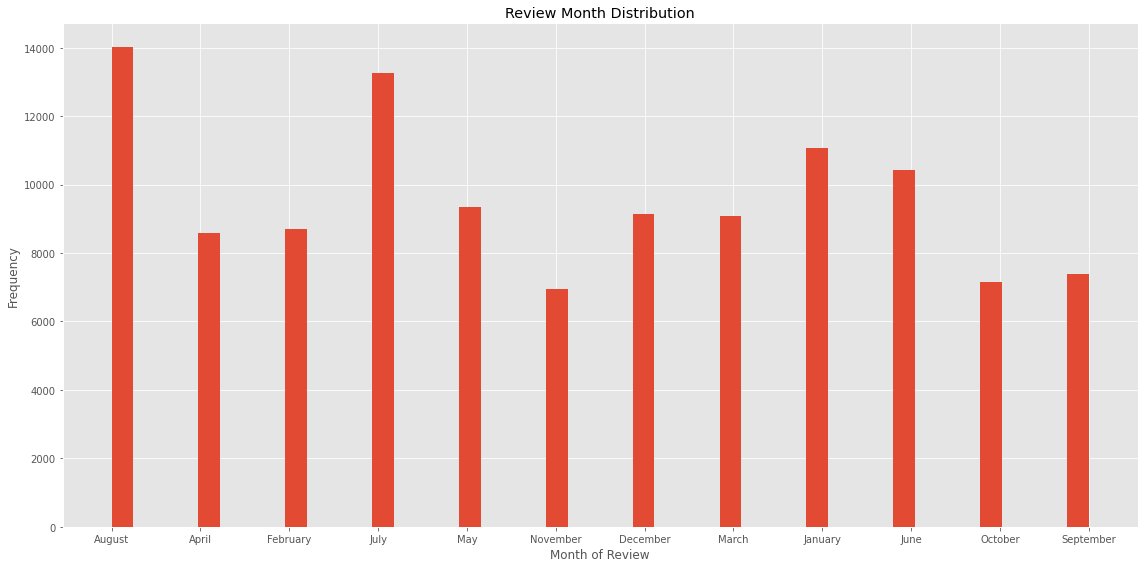

In [ ]:
# Let's look at the 'review_month' distribution

fig, ax = plt.subplots(figsize = (16, 8))
ax.hist(ratings_pd['review_month'], bins = 'auto')
ax.set_title('Review Month Distribution')
ax.set_xlabel('Month of Review')
ax.set_ylabel('Frequency')

plt.xticks(rotation = 0)
plt.tight_layout()
plt.show;

August and July are the most popular months to leave reviews followed by January. 

#### Products 

In [ ]:
# getting the counts of product_name
from collections import Counter

products = Counter(ratings_pd.product_title)

product_name = []
popularity = []

for item in products.most_common(15): 
    product_name.append(item[0])
    popularity.append(item[1])

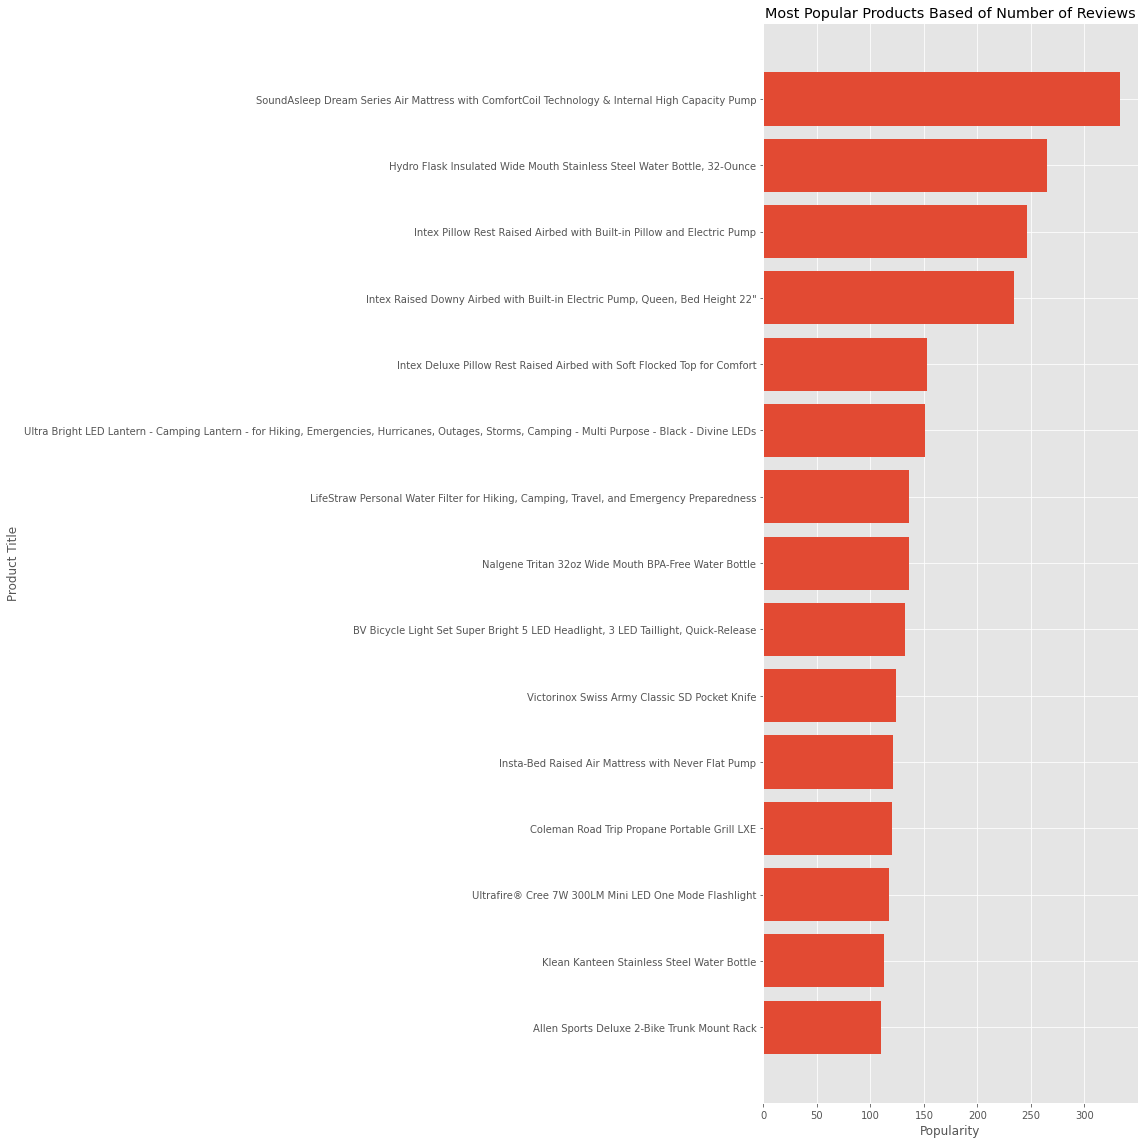

In [ ]:
# product review dist

product_name.reverse()
popularity.reverse()

fig, ax = plt.subplots(figsize = (16, 16))
ax.barh(product_name, popularity)

ax.set_title('Most Popular Products Based of Number of Reviews')
ax.set_xlabel('Popularity')
ax.set_ylabel('Product Title')

plt.tight_layout()
plt.show;

In [ ]:
# limiting the dataframe to two columns to perform aggregation based on frequency of reviews for products.

df = ratings_pd[['review_date', 'product_title']]
df.head()

,review_date,product_title
0,2015-08-27,WaterVault Thermos Water Bottle - Double Insul...
1,2011-04-05,Stearns Sospenders Manual Inflatable Life Jacket
2,2015-02-14,Vader Bicycle Cycling Bike Road Offroad MTB Mo...
3,2014-04-12,"Shimano Acera SL-M310 Rapid Fire Shifter, Righ..."
4,2013-07-28,Women's Cycling Biking Pants Underwear Bike Bi...


In [ ]:
# aggregation by 'product_title' and year
df = df.set_index(['review_date'])

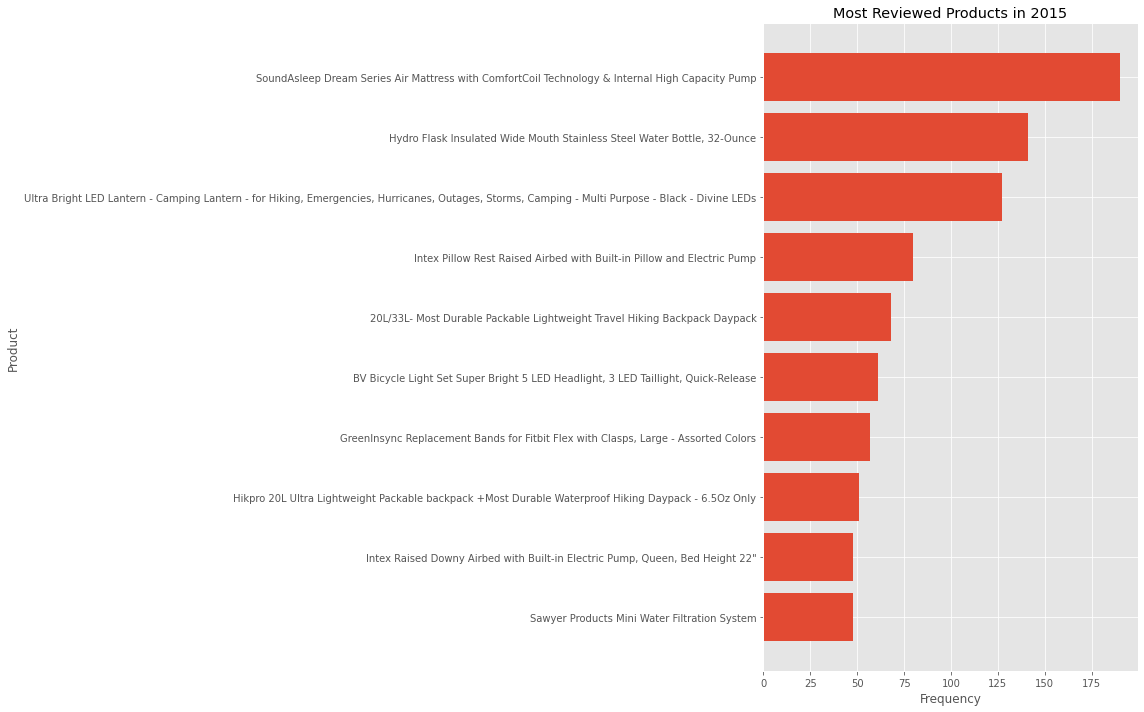

In [ ]:
# most popular items in 2015
df_2015 = df.loc['2015']

# distibution of product reviews in 2015
products_2015 = Counter(df_2015.product_title)

product_title = []
frequency = []

for item in products_2015.most_common(10): 
    product_title.append(item[0])
    frequency.append(item[1])

# product dist

product_title.reverse()
frequency.reverse()

fig, ax = plt.subplots(figsize = (16, 10))
ax.barh(product_title, frequency)

ax.set_title('Most Reviewed Products in 2015')
ax.set_xlabel('Frequency')
ax.set_ylabel('Product')

plt.tight_layout()
plt.show;

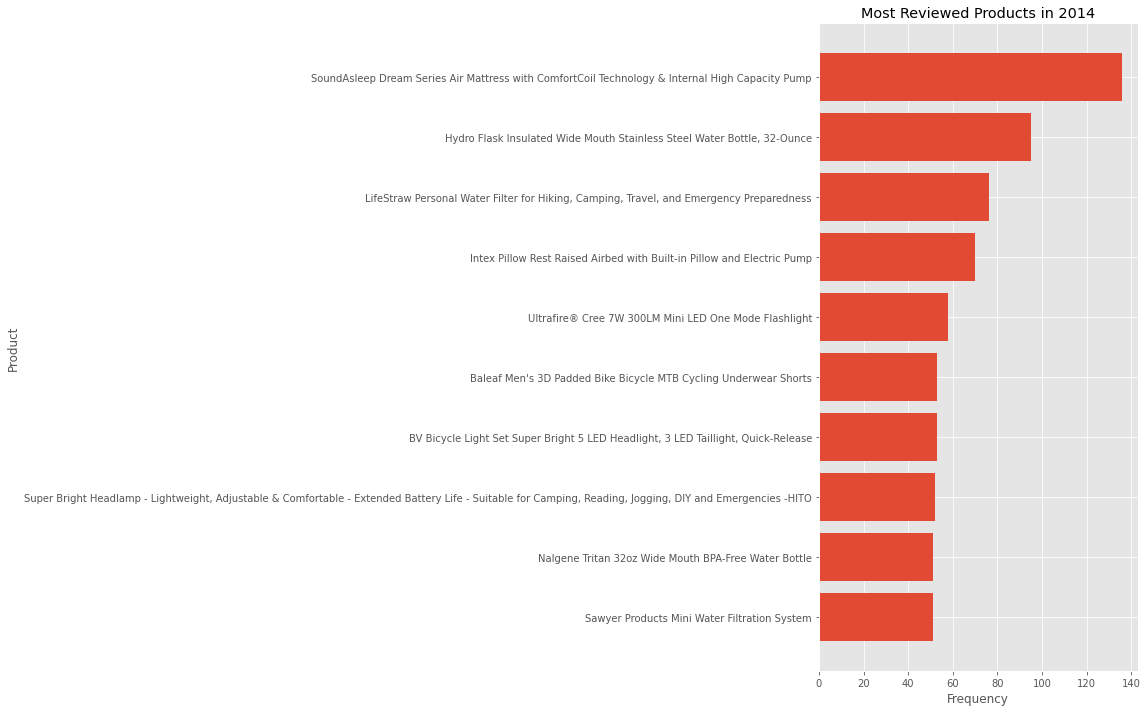

In [ ]:
# most popular items in 2014
df_2014 = df.loc['2014']

# distibution of product reviews in 2014
products_2014 = Counter(df_2014.product_title)

product_title = []
frequency = []

for item in products_2014.most_common(10): 
    product_title.append(item[0])
    frequency.append(item[1])

# product dist

product_title.reverse()
frequency.reverse()

fig, ax = plt.subplots(figsize = (16, 10))
ax.barh(product_title, frequency)

ax.set_title('Most Reviewed Products in 2014')
ax.set_xlabel('Frequency')
ax.set_ylabel('Product')

plt.tight_layout()
plt.show;

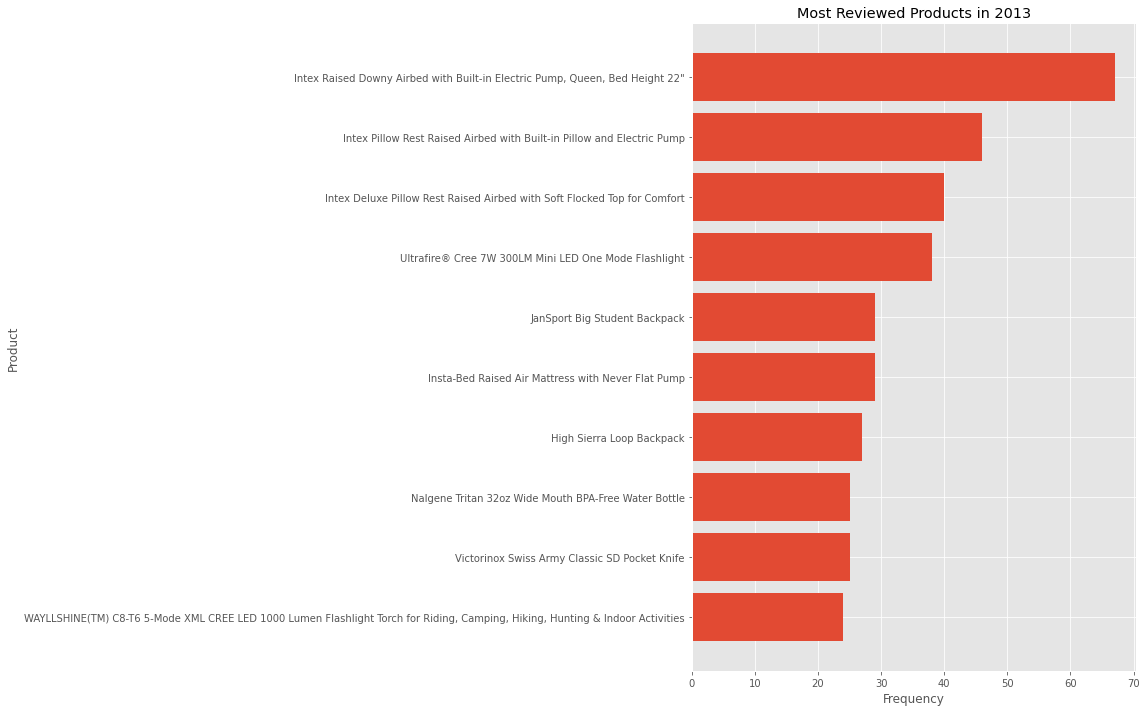

In [ ]:
# most popular items in 2013
df_2013 = df.loc['2013']

# distibution of product reviews in 2013
products_2013 = Counter(df_2013.product_title)

product_title = []
frequency = []

for item in products_2013.most_common(10): 
    product_title.append(item[0])
    frequency.append(item[1])

# product dist

product_title.reverse()
frequency.reverse()

fig, ax = plt.subplots(figsize = (16, 10))
ax.barh(product_title, frequency)

ax.set_title('Most Reviewed Products in 2013')
ax.set_xlabel('Frequency')
ax.set_ylabel('Product')

plt.tight_layout()
plt.show;

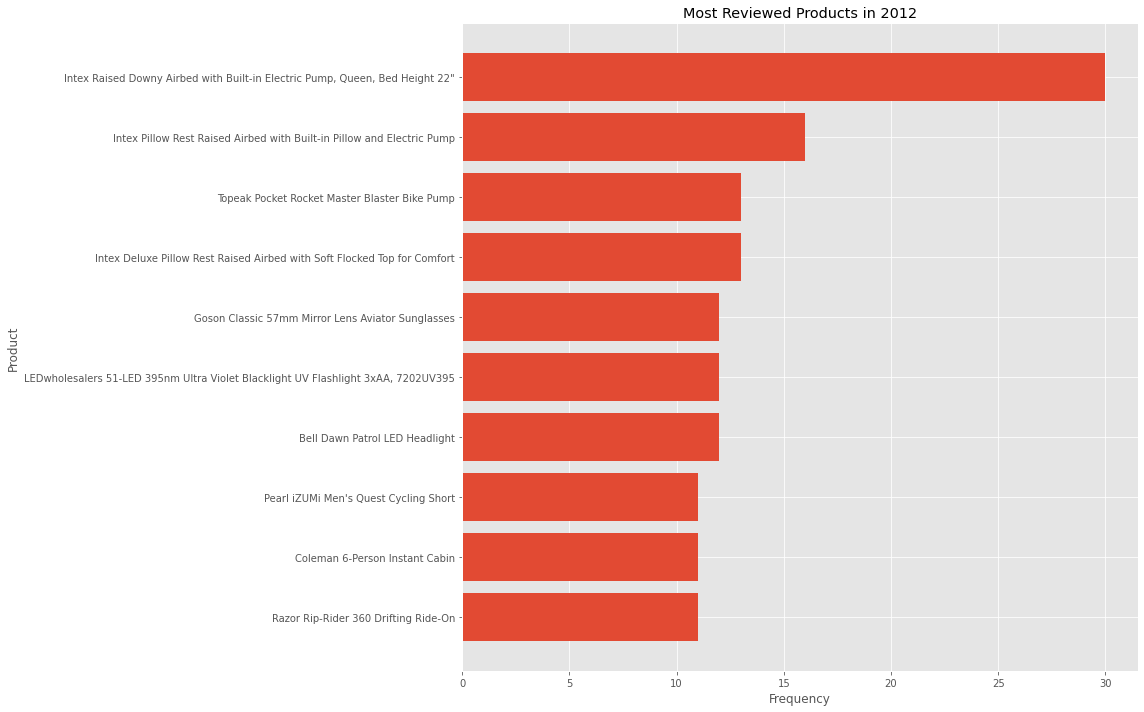

In [ ]:
# most popular items in 2012
df_2012 = df.loc['2012']

# distibution of product reviews in 2012
products_2012 = Counter(df_2012.product_title)

product_title = []
frequency = []

for item in products_2012.most_common(10): 
    product_title.append(item[0])
    frequency.append(item[1])

# product dist

product_title.reverse()
frequency.reverse()

fig, ax = plt.subplots(figsize = (16, 10))
ax.barh(product_title, frequency)

ax.set_title('Most Reviewed Products in 2012')
ax.set_xlabel('Frequency')
ax.set_ylabel('Product')

plt.tight_layout()
plt.show;

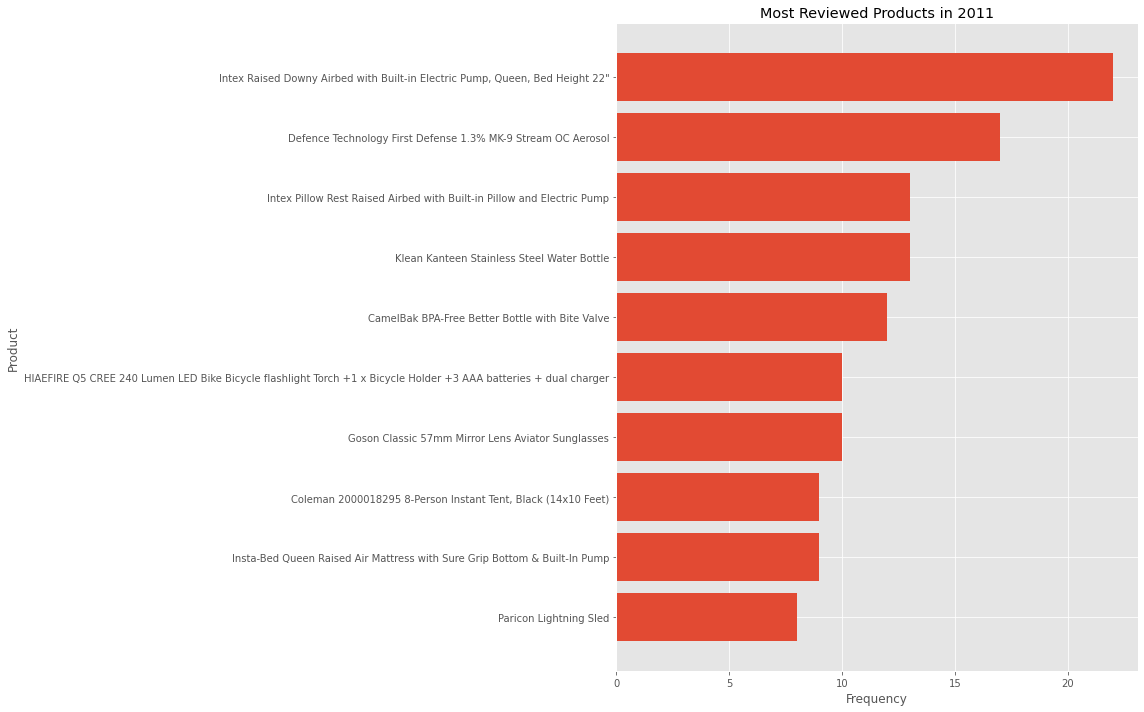

In [ ]:
# most popular items in 2011
df_2011 = df.loc['2011']

# distibution of product reviews in 2011
products_2011 = Counter(df_2011.product_title)

product_title = []
frequency = []

for item in products_2011.most_common(10): 
    product_title.append(item[0])
    frequency.append(item[1])

# product dist

product_title.reverse()
frequency.reverse()

fig, ax = plt.subplots(figsize = (16, 10))
ax.barh(product_title, frequency)

ax.set_title('Most Reviewed Products in 2011')
ax.set_xlabel('Frequency')
ax.set_ylabel('Product')

plt.tight_layout()
plt.show;

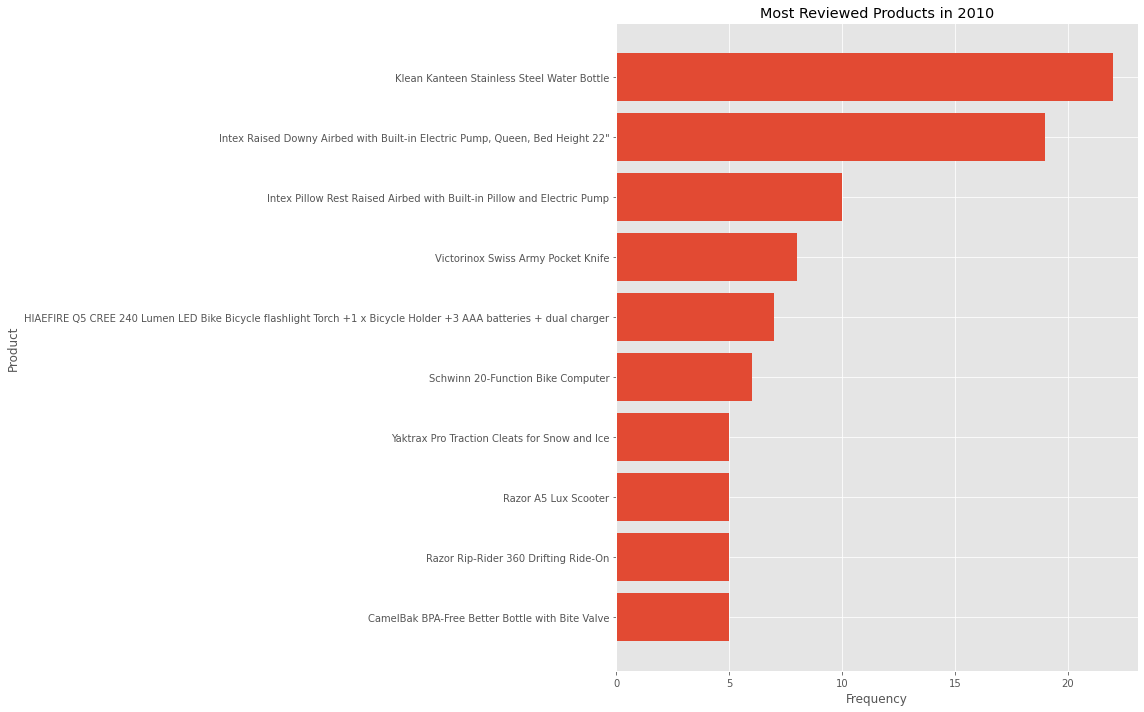

In [ ]:
# most popular items in 2010
df_2010 = df.loc['2010']

# distibution of product reviews in 2010
products_2010 = Counter(df_2010.product_title)

product_title = []
frequency = []

for item in products_2010.most_common(10): 
    product_title.append(item[0])
    frequency.append(item[1])

# product dist

product_title.reverse()
frequency.reverse()

fig, ax = plt.subplots(figsize = (16, 10))
ax.barh(product_title, frequency)

ax.set_title('Most Reviewed Products in 2010')
ax.set_xlabel('Frequency')
ax.set_ylabel('Product')

plt.tight_layout()
plt.show;

#### Customers

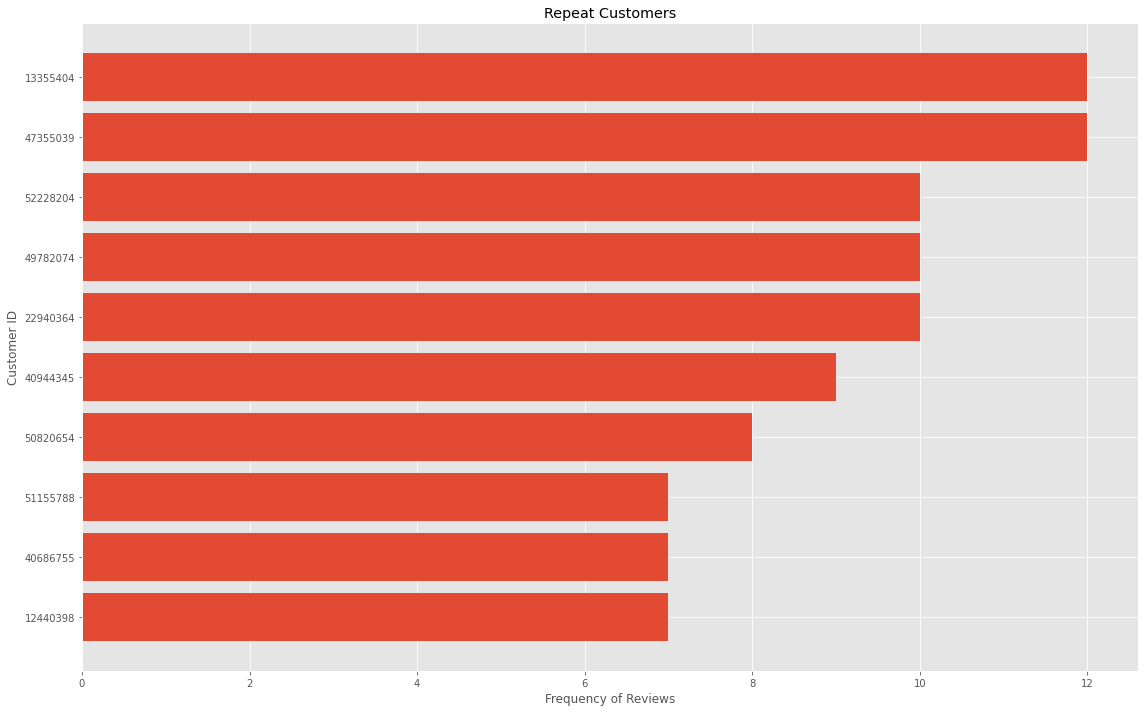

In [ ]:
# reviews per customer
customers = Counter(ratings_pd.customer_id)

customer = []
frequency = []

for item in customers.most_common(10): 
    customer.append(item[0])
    frequency.append(item[1])

# product dist

customer.reverse()
frequency.reverse()

fig, ax = plt.subplots(figsize = (16, 10))
ax.barh(customer, frequency)

ax.set_title('Repeat Customers')
ax.set_xlabel('Frequency of Reviews')
ax.set_ylabel('Customer ID')

plt.tight_layout()
plt.show;

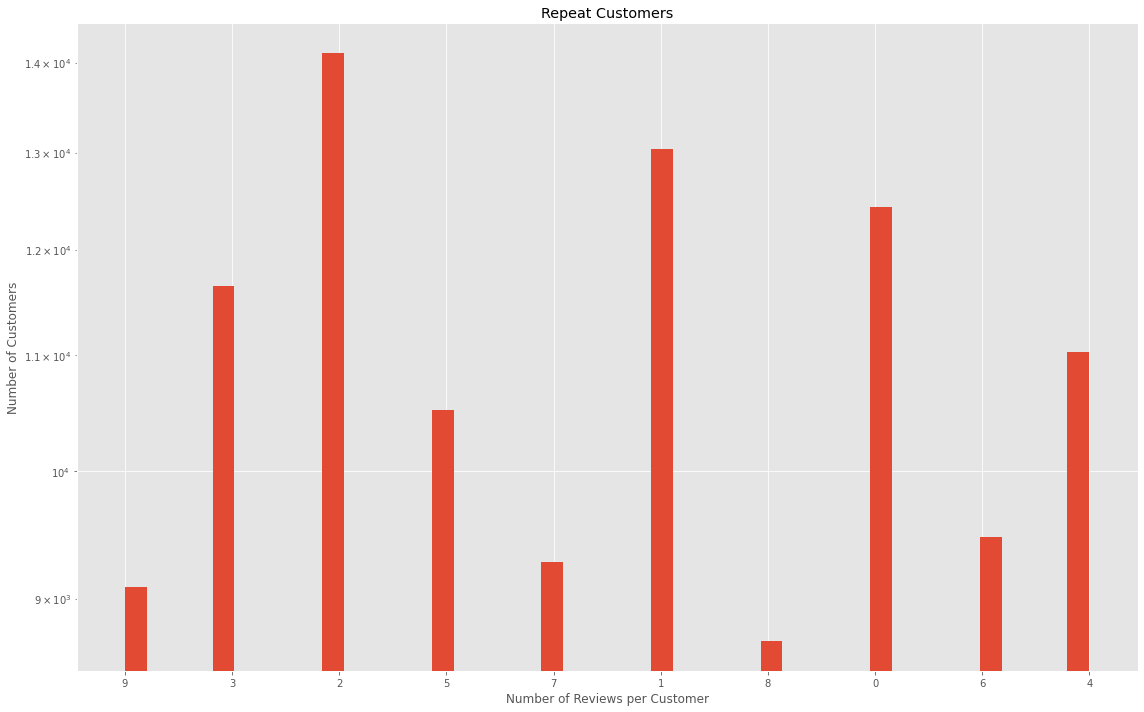

In [ ]:
customers = Counter(ratings_pd.customer_id)

customer = []
frequency = []

for item in customers: 
    customer.append(item[0])
    frequency.append(item[1])

fig, ax = plt.subplots(figsize = (16, 10))
ax.hist(frequency, bins = 'auto', log = True)

ax.set_title('Repeat Customers')
ax.set_xlabel('Number of Reviews per Customer')
ax.set_ylabel('Number of Customers')

plt.tight_layout()
plt.show;

The data represents customers that left from 0-12 reviews with the higher number of customers leaving 1-2 reviews. 

## Conclusion

Conclusions based on EDA: \
- Rating scale is 1-5. 
- Ratings left between 2000-10-08 - 2015-08-31.
- Number of customers in this dataset: 109308
- Number of products: 59607
- August and July are the most popular months to leave reviews followed by January for Outdoor products. 
- Since 2008 the number of reviews has been progressively increasing each year with more than doubling at 2013.
- Over 62% of customers left 5 star rating review followed by ~18% of 4 star rating. 
- Customers tend to leave reviews at the beginning of the week. 
- The data represents customers that left 0-12 reviews with the higher number of customers leaving 1-2 reviews. 
